In [1]:
import time
import numpy as np
import os
import random
import math
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import scipy.misc as misc
import copy
%matplotlib inline

C:\Users\Seth\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
data_directory = "/data/"
training_filename = "training.csv"
batch_size = 36
num_epochs=500
dropout = True
use_ConvNet = True
learning_amount= 0.03
momentum_amount = 0.9
learn_decay = False
momentum_inc = False
opt = "MOM"


model_name = "ConvNet" + str(learning_amount) + "_" + str(num_epochs) + "DA" + "Dropout" + "FlipAug3"
model_filename = model_name + ".ckpt"
model_directory = os.getcwd() + "/Models5/" + model_name
model_path = model_directory + "/" + model_filename

# Images are 96 x 96 grayscale with 15 features using (x, y) coordinates
image_size = 96
num_channels = 1 # grayscale
num_classes = 30


In [50]:
class MiniBatcher(object):
    def __init__(self, batch_size, shuffle=False, seed=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random = np.random.RandomState(seed)

    def __call__(self, value, label=None):
        if self.shuffle:
            _shuffle_arrays([value, label] if label is not None else [value], self.random)
        self.value, self.label = value, label
        return self

    def __iter__(self):
        for i in range((len(self.value) + self.batch_size - 1) // self.batch_size):
            slice_amount = slice(i * self.batch_size, (i + 1) * self.batch_size)
            value_slice = _slicer(self.value, slice_amount)
            if self.label is not None:
                label_slice = _slicer(self.label, slice_amount)
            else:
                label_slice = None
            yield self.transform(value_slice, label_slice)

    def transform(self, Xb, yb):
        return Xb, yb

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state
    
class AugBatcher(MiniBatcher):
    
    def __init__(self, batch_size, shuffle=False, seed=1, add_flips=False, add_noise=False, add_bright=False, add_rotate=False):
        super(AugBatcher, self).__init__(batch_size, shuffle=False, seed=1)
        self.add_flips = add_flips
        self.add_noise = add_noise
        self.add_bright = add_bright
        self.add_rotate = add_rotate
        self.flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
        
    def transform(self, x_data, y_data):
        x_data, y_data = super(AugBatcher, self).transform(x_data, y_data)
        
        #Flip
        bs = x_data.shape[0]
        indices = np.random.choice(bs, int(bs / 2), replace=False)
        x_data[indices] = x_data[indices, :, ::-1, :]

        if self.add_flips:
            # 50% chance to flip
            data_shape = x_data.shape[0]
            indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
            x_data[indices] = x_data[indices, :, ::-1]

            if y_data is not None:
                
                y_data[indices, ::2] = y_data[indices, ::2] * -1

                # Swap places, e.g. left_eye_center_x -> right_eye_center_x
                for a, b in self.flip_indices:
                    y_data[indices, a], y_data[indices, b] = (y_data[indices, b], y_data[indices, a])
        return x_data, y_data

def _slicer(array, slice_amount):
    return array[slice_amount]

def _shuffle_arrays(arrays, random):
    random_state = random.get_state()
    for array in arrays:
        random.set_state(random_state)
        random.shuffle(array)
        
def rotatePoint(centerPoint,point,angle):
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

# Load Data

In [36]:
def loadData(filename):
    
    df = pd.read_csv(filename)

    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    df = df.dropna()

    values = np.vstack(df['Image'].values) / 255.
    values = values.astype(np.float32)

    labels = df[df.columns[:-1]].values
    labels = (labels - 48) / 48  
    values, labels = shuffle(values, labels, random_state=3)  
    labels = labels.astype(np.float32)

    return values, labels

In [6]:
image_values, image_labels = loadData(os.getcwd() + data_directory + training_filename)
image_values = np.reshape(image_values, [-1, image_size, image_size, 1])

In [6]:
def splitData(data, data2, percentage):
    data11 = data[:int(len(data)*percentage)]
    data12 = data[int(len(data)*percentage):]
    
    data21 = data2[:int(len(data2)*percentage)]
    data22 = data2[int(len(data2)*percentage):]
    
    return data11, data12, data21, data22

## Train/Validation/Test Split

In [64]:
train_images, valid_images, train_labels, valid_labels = splitData(image_values, image_labels, 0.7)

valid_images, test_images, valid_labels, test_labels = splitData(valid_images, valid_labels, 0.5)

# Build Network

In [8]:
def createConvolutionLayer(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    print("conv: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, features, depth],
                             initializer = tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))
    
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    added = tf.nn.bias_add(convolution, biases)
    
    total_parameters = kernel_size*kernel_size*features*depth + depth
    print("Created Convolution Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.relu(added)

In [9]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    total_parameters = x_input.get_shape()[1] * width + width
    
    print("Created Fully Connected Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [10]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLU in graph
    # 
    print("Created RELU Activation Function")
    return tf.nn.relu(x_input)

In [11]:
def createPoolingLayer(x_input, kernel_size):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    
    print("Created Pooling Layer: Downsample:" + str(kernel_size))
    return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size,kernel_size, 1], padding='SAME')

### Simple 2 layer neural network

In [12]:
def createSimpleNetwork(model_input):
    with tf.variable_scope('input'):
        input_layer = tf.reshape(model_input, [-1, image_size * image_size])
    with tf.variable_scope('hidden'):
        hidden_fully_connected_layer = createFullyConnectedLayer(input_layer, 100)
    relu_layer = createLinearRectifier(hidden_fully_connected_layer)
    with tf.variable_scope('out'):
        model_output = createFullyConnectedLayer(relu_layer, 30)
        
    print("Simple Network Created")
    return model_output

### Convolutional Neural Network

In [13]:
def createConvNetwork(x_input, is_train):
    # Define convolution layers
    with tf.variable_scope('conv1'):
        convolution_layer1 = createConvolutionLayer(x_input, 3, 1, 32)
        pooling_layer1 = createPoolingLayer(convolution_layer1, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer1 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer1, keep_prob = 0.9 if dropout else 1.0), lambda: pooling_layer1)
    with tf.variable_scope('conv2'):
        convolution_layer2 = createConvolutionLayer(pooling_layer1, 2, 32, 64)
        pooling_layer2 = createPoolingLayer(convolution_layer2, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer2 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer2, keep_prob = 0.8 if dropout else 1.0), lambda: pooling_layer2)
    with tf.variable_scope('conv3'):
        convolution_layer3 = createConvolutionLayer(pooling_layer2, 2, 64, 128)
        pooling_layer3 = createPoolingLayer(convolution_layer3, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer3 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer3, keep_prob = 0.7 if dropout else 1.0), lambda: pooling_layer3)
    
    # Flatten output to connect to fully connected layers
    print("fc: input size before flattening: " + str(pooling_layer3.get_shape()))
    pooling_layer3_shape = pooling_layer3.get_shape().as_list()
    pooling_layer3_flattened = tf.reshape(pooling_layer3, [-1, pooling_layer3_shape[1] * pooling_layer3_shape[2] * pooling_layer3_shape[3]])
    
    # Define fully connected layers
    with tf.variable_scope('fc1'):
        fully_connected_layer1 = createFullyConnectedLayer(pooling_layer3_flattened, 1000)
        fully_connected_relu1 = createLinearRectifier(fully_connected_layer1)
        fully_connected_relu1 = tf.cond(is_train, lambda: tf.nn.dropout(fully_connected_relu1, keep_prob = 0.5 if dropout else 1.0), lambda: fully_connected_relu1)
    with tf.variable_scope('fc2'):
        fully_connected_layer2 = createFullyConnectedLayer(fully_connected_relu1, 1000)
        fully_connected_relu2 = createLinearRectifier(fully_connected_layer2)
    with tf.variable_scope('out'):
        output = createFullyConnectedLayer(fully_connected_relu2, num_classes)
        print("out: " + str(output.get_shape()))
    return output

In [14]:
def getLoss(values, labels, session):
    loss = []
    batch = MiniBatcher(batch_size = 128)
    for batch_values, batch_labels in batch(values, labels):
        loss_batch = session.run(model_loss, feed_dict = {model_input : batch_values, model_output : batch_labels, model_training : False})
        loss.append(loss_batch)
    return np.mean(loss)

In [15]:
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

In [16]:
def saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, name):
    df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})
    writer = pd.ExcelWriter(model_path + name + '.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='Sheet1')
    writer.save()

In [45]:
def trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, noise, bright, rotate):
    start = time.time()
    train_loss_list = []
    valid_loss_list = []
    time_list = []
    epoch_list = []
    print("TRAINING: " + model_name)

    with tf.Session(graph = graph) as session:

        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if os.path.exists(model_directory):
            print("Loading model...")
            load_path = saver.restore(session, model_path)

        for epoch in range(num_epochs):
            current_epoch = epoch
            batch = AugBatcher(batch_size=batch_size, shuffle=True, add_flips=flip, add_noise=noise, add_bright=bright, add_rotate=rotate)
            for batch_data, batch_labels in batch(train_images, train_labels):
                feed_dict = {model_input: batch_data, model_output: batch_labels, model_training: True}
                # train model
                session.run([model_optimizer], feed_dict = feed_dict)

            #Store train and validation losses
            if current_epoch % 10 == 0:
                train_loss = getLoss(train_images, train_labels, session)
                train_loss_list.append(train_loss)
                valid_loss = getLoss(valid_images, valid_labels, session)
                valid_loss_list.append(valid_loss)

                current_time = time.time() - start
                hours, minutes, seconds = getTime(current_time)
                if learn_decay:
                    print("Epoch[%4d]" % epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f" % learning_rate.eval())
                else:
                    print("Epoch[%4d]" % epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f" % learning_rate)
                
                time_list.append(current_time)
                epoch_list.append(current_epoch)

            if current_epoch % 300 == 0:
                if not os.path.exists(model_directory):
                    os.mkdir(model_directory)
                print("Saving Model...")    
                save_path = saver.save(session, model_path)
            # Evaluate on test dataset.
        test_loss = getLoss(test_images, test_labels, session)
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) #RMSE
        if not os.path.exists(model_directory):
            os.mkdir(model_directory)
        print("Saving Model...")
        save_path = saver.save(session, model_path)
        saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, 'Loss3')

In [46]:
graph = tf.Graph()

with graph.as_default():
    
    model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    model_output = tf.placeholder(tf.float32, shape=(None, num_classes))
    model_training = tf.placeholder(tf.bool)
    
    current_epoch = tf.Variable(0, trainable=False)
    #Define Parameters

    if learn_decay:
        print("learn decay on")
        learning_rate = tf.train.exponential_decay(learning_amount, current_epoch, decay_steps=num_epochs, decay_rate=0.05)
    else:
        learning_rate = learning_amount
    
    if momentum_inc:
        m_min = 0.9
        m_max = 0.99
        print("momentum increase on")
        momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
    else:
        momentum_rate = momentum_amount
    # get model
    if(use_ConvNet):
        with tf.variable_scope(model_name):
            model_predictions = createConvNetwork(model_input, model_training)
    else:
        with tf.variable_scope(model_name):
            model_predictions = createSimpleNetwork(model_input)
    
    model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))
    
    if opt == "MOM":
        print("Using Momentum Optimizer")
        model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss)
    elif opt == "ADAM":
        print("Using ADAM Optimizer")
        model_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    else:
        print("Using SGD Optimizer")
        model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(model_loss)


conv: input size: (?, 96, 96, 1)
Created Convolution Layer: Input(?, 96, 96, 1) Parameters(320)
Created Pooling Layer: Downsample:2
conv: input size: (?, 48, 48, 32)
Created Convolution Layer: Input(?, 48, 48, 32) Parameters(8256)
Created Pooling Layer: Downsample:2
conv: input size: (?, 24, 24, 64)
Created Convolution Layer: Input(?, 24, 24, 64) Parameters(32896)
Created Pooling Layer: Downsample:2
fc: input size before flattening: (?, 12, 12, 128)
Created Fully Connected Layer: Input(?, 18432) Parameters(18433000)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 1000) Parameters(1001000)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 1000) Parameters(30030)
out: (?, 30)
Using Momentum Optimizer


In [51]:
flip = True
rotate = False
noise = False
bright = False

trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, 128, model_name, flip, noise, bright, rotate)

TRAINING: ConvNet0.03_500DADropoutFlipAug3
Epoch[   0]0: 0: 1 0.028488  0.027927 0.030000
Saving Model...
Epoch[  10]0: 0:12 0.008739  0.008481 0.030000
Epoch[  20]0: 0:21 0.007594  0.007344 0.030000
Epoch[  30]0: 0:31 0.006899  0.006662 0.030000
Epoch[  40]0: 0:40 0.006330  0.006106 0.030000
Epoch[  50]0: 0:49 0.006091  0.005872 0.030000
Epoch[  60]0: 0:59 0.005706  0.005499 0.030000
Epoch[  70]0: 1: 8 0.005516  0.005316 0.030000
Epoch[  80]0: 1:17 0.005438  0.005245 0.030000
Epoch[  90]0: 1:27 0.005291  0.005100 0.030000
Epoch[ 100]0: 1:36 0.005238  0.005050 0.030000
Epoch[ 110]0: 1:46 0.005009  0.004835 0.030000
Epoch[ 120]0: 1:55 0.004930  0.004756 0.030000
Epoch[ 130]0: 2: 5 0.004768  0.004609 0.030000
Epoch[ 140]0: 2:14 0.004671  0.004517 0.030000
Epoch[ 150]0: 2:23 0.004600  0.004452 0.030000
Epoch[ 160]0: 2:33 0.004527  0.004382 0.030000
Epoch[ 170]0: 2:42 0.004498  0.004359 0.030000
Epoch[ 180]0: 2:51 0.004443  0.004309 0.030000
Epoch[ 190]0: 3: 1 0.004423  0.004290 0.030000
E

## Plot predicted labels on faces

In [31]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    #pred = session.run(model_predictions, feed_dict={model_input: np.reshape(new_image, [1, 96, 96, 1]), model_training:False})
    pred = session.run(model_predictions, feed_dict={model_input: test_images, model_training:False})
    #valid_loss = getLoss(valid_images, valid_labels, session)
    #loss = session.run(loss_function, feed_dict={tf_x_batch: x_valid, y_output: y_valid, is_training:False})
    #print(loss)

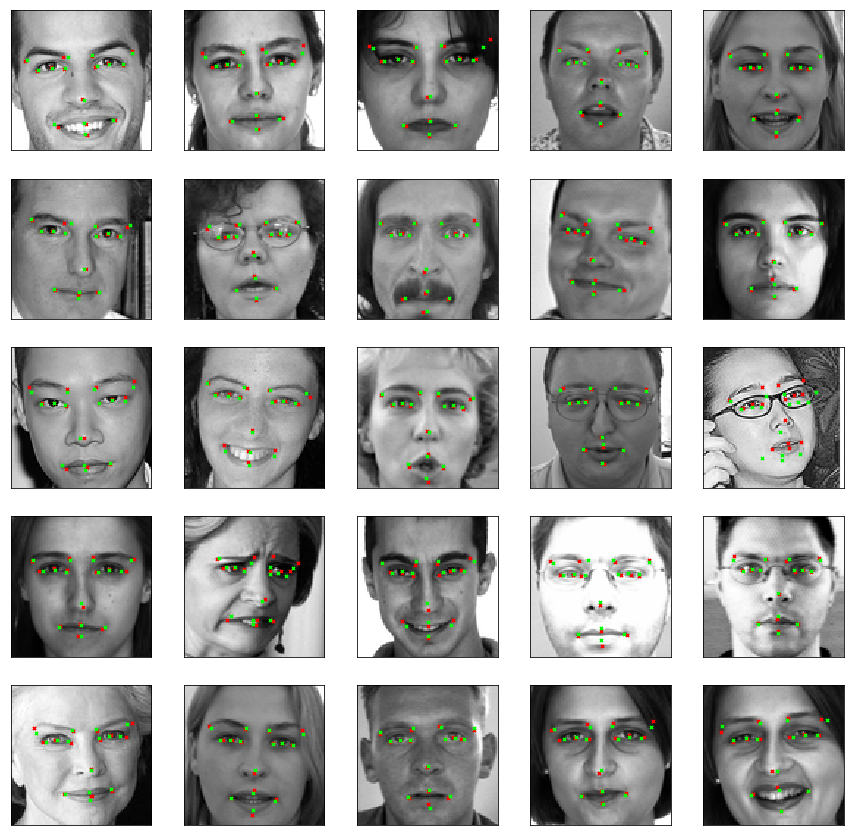

In [32]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = test_images[i]
    #img = new_image
    img = np.reshape(img, [96, 96])
    y = test_labels[i]
    y2 = pred[i]
    axis.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

### Cross Validation for parameter tuning

In [22]:
kfolds = 3
#kfolds loop
#new name
#train
print("hello")
momentum_steps = [0.9, 0.8, 0.7] 

learning_steps = [0.05, 0.5, 1]
flip = False
rotate = False
noise = False
bright = False

skf = KFold(n_splits=kfolds, random_state=None, shuffle=False)
i = 0
for train_index, test_index in skf.split(image_values):
    print(i)
    kfolds2 = 3
    momentum_rate = momentum_steps[i]
    train_images1 = [image_values[i] for i in train_index]
    train_labels1 = [image_labels[i] for i in train_index]
    
    test_images = [image_values[i] for i in test_index]
    test_labels = [image_labels[i] for i in test_index]
    j = 0
    skf2 = KFold(n_splits=kfolds2, random_state=None, shuffle=False)
    for train_index2, valid_index in skf2.split(train_images1):
        print(j)
        
        train_images = np.asarray([train_images1[i] for i in train_index2])
        train_labels = np.asarray([train_labels1[i] for i in train_index2])
        valid_images = np.asarray([train_images1[i] for i in valid_index])
        valid_labels = np.asarray([train_labels1[i] for i in valid_index])
        

    
        graph = tf.Graph()

        learn_decay = False
        with graph.as_default():

            model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
            model_output = tf.placeholder(tf.float32, shape=(None, num_classes))
            model_training = tf.placeholder(tf.bool)

            current_epoch = tf.Variable(0)
            #Define Parameters
            num_epochs=200
            if learn_decay:
                #learning_rate = tf.train.exponential_decay(learning_steps[j], current_epoch, decay_steps=num_epochs, decay_rate=0.03)
                learning_rate = tf.train.exponential_decay(
                                  learning_steps[j],                # Base learning rate.
                                  current_epoch,  # Current index into the dataset.
                                  num_epochs,          # Decay step.
                                  0.9,                # Decay rate.
                                  staircase=True)
            else:
                learning_rate = learning_steps[j]
                print("LEARNING RATE:" + str(learning_rate))

            if momentum_inc:
                m_min = 0.9
                m_max = 0.99
                momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
            else:
                momentum_rate = momentum_amount
                    #Model Name
            model_name = "ConvNet-CV" + "Mom" + str(momentum_rate) + str("LRN") + str(learning_rate) 
            model_filename = model_name + ".ckpt"
            model_directory = os.getcwd() + "/Models5/" + model_name
            model_path = model_directory + "/" + model_filename
            # get model
            #with tf.variable_scope(model_name):
            #    model_predictions = createSimpleNetwork(model_input)
            with tf.variable_scope(model_name):
                model_predictions = createConvNetwork(model_input, model_training)

            model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))

            model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss)
        
        print("hello")

        trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, noise, bright, rotate)
        
        j = j + 1
    i = i + 1

hello
0
0
LEARNING RATE:0.05
conv: input size: (?, 96, 96, 1)
Created Convolution Layer: Input(?, 96, 96, 1) Parameters(320)
Created Pooling Layer: Downsample:2
conv: input size: (?, 48, 48, 32)
Created Convolution Layer: Input(?, 48, 48, 32) Parameters(8256)
Created Pooling Layer: Downsample:2
conv: input size: (?, 24, 24, 64)
Created Convolution Layer: Input(?, 24, 24, 64) Parameters(32896)
Created Pooling Layer: Downsample:2
fc: input size before flattening: (?, 12, 12, 128)
Created Fully Connected Layer: Input(?, 18432) Parameters(18433000)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 1000) Parameters(1001000)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 1000) Parameters(30030)
out: (?, 30)
hello
TRAINING: ConvNet-CVMom0.9LRN0.05
Epoch[   0]0: 0: 1 0.043593  0.043849 0.050000
Saving Model...
Epoch[  10]0: 0: 8 0.011227  0.011424 0.050000
Epoch[  20]0: 0:14 0.008866  0.009111 0.050000
Epoch[  30]0: 0:21 0.008372  0.008628 0.050

KeyboardInterrupt: 

In [193]:
kfolds = 3
#kfolds loop
#new name
#train
print("hello")
momentum_steps = [0, 1, 2] 

learning_steps = [0.0001, 0.001, 0.01, 0.1]
flip = False
rotate = False
noise = False
bright = False
learn_decay = False
dropout = False
use_ConvNet = True
num_epochs = 200

skf = KFold(n_splits=kfolds, random_state=None, shuffle=False)
i = 0
for train_index, test_index in skf.split(image_values):
    print(i)
    kfolds2 = 4
    momentum_rate = momentum_steps[i]
    train_images1 = [image_values[i] for i in train_index]
    train_labels1 = [image_labels[i] for i in train_index]
    
    test_images = [image_values[i] for i in test_index]
    test_labels = [image_labels[i] for i in test_index]
    j = 0
    skf2 = KFold(n_splits=kfolds2, random_state=None, shuffle=False)
    for train_index2, valid_index in skf2.split(train_images1):
        print(j)
        learning_rate = learning_steps[j]
        
        train_images = np.asarray([train_images1[i] for i in train_index2])
        train_labels = np.asarray([train_labels1[i] for i in train_index2])
        valid_images = np.asarray([train_images1[i] for i in valid_index])
        valid_labels = np.asarray([train_labels1[i] for i in valid_index])
                
        graph = tf.Graph()
        
        with graph.as_default():

            model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
            model_output = tf.placeholder(tf.float32, shape=(None, num_classes))
            model_training = tf.placeholder(tf.bool)

            current_epoch = tf.Variable(0, trainable=False)
            #Define Parameters

            if False:
                #learning_rate = tf.train.exponential_decay(learning_steps[j], current_epoch, decay_steps=num_epochs, decay_rate=0.03)
                learning_rate = tf.train.exponential_decay(
                                  learning_steps[j],                # Base learning rate.
                                  current_epoch,  # Current index into the dataset.
                                  num_epochs,          # Decay step.
                                  0.9,                # Decay rate.
                                  staircase=True)
            else:
                learning_rate = learning_steps[j]
                print("LEARNING RATE:" + str(learning_rate))

            if momentum_inc:
                m_min = 0.9
                m_max = 0.99
                momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
            else:
                momentum = momentum_amount

            #Model Name
            model_name = "ConvNet-CV" + "_Opt" + str(i) + str("_LRN") + str(learning_steps[j]) + "_Epochs" + str(num_epochs)
            model_filename = model_name + ".ckpt"
            model_directory = os.getcwd() + "/Models5/" + model_name
            model_path = model_directory + "/" + model_filename

            # get model
            if(use_ConvNet):
                with tf.variable_scope(model_name):
                    model_predictions = createConvNetwork(model_input, model_training)
            else:
                with tf.variable_scope(model_name):
                    model_predictions = createSimpleNetwork(model_input)

            model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))

            if momentum_steps[i] == 0:
                model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss, global_step = current_epoch)
            elif momentum_steps[i] == 1:
                model_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model_loss, global_step = current_epoch)
            else:
                model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(model_loss, global_step = current_epoch)



        trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, noise, bright, rotate)

        j = j + 1
    i = i + 1

hello
0
0
LEARNING RATE:0.0001
conv: input size: (?, 96, 96, 1)
Created Convolution Layer: Input(?, 96, 96, 1) Parameters(320)
Created Pooling Layer: Downsample:2
conv: input size: (?, 48, 48, 32)
Created Convolution Layer: Input(?, 48, 48, 32) Parameters(8256)
Created Pooling Layer: Downsample:2
conv: input size: (?, 24, 24, 64)
Created Convolution Layer: Input(?, 24, 24, 64) Parameters(32896)
Created Pooling Layer: Downsample:2
fc: input size before flattening: (?, 12, 12, 128)
Created Fully Connected Layer: Input(?, 18432) Parameters(18433000)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 1000) Parameters(1001000)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 1000) Parameters(30030)
out: (?, 30)
TRAINING: ConvNet-CV_Opt0_LRN0.0001_Epochs200
Epoch[   0]0: 0: 1 0.155828  0.154056 0.000100
Saving Model...
Epoch[  10]0: 0: 8 0.151915  0.150181 0.000100
Epoch[  20]0: 0:13 0.148106  0.146406 0.000100
Epoch[  30]0: 0:19 0.144400  0.1427

In [167]:
j

1

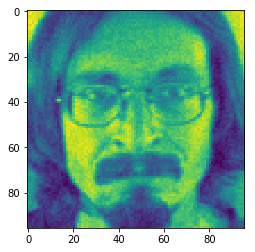

KeyboardInterrupt: 

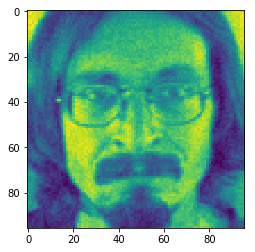

In [145]:
from IPython import display

flip = False
rotate = False
noise = False
bright = False
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    pred = session.run(model_predictions, feed_dict={model_input: test_images, model_training:False})
    
batch = AugBatchIterator(batch_size=batch_size, shuffle=True, add_flips=flip, add_noise=noise, add_bright=bright, add_rotate=rotate)
for batch_data, batch_labels in batch(train_images, train_labels):
    
    plt.imshow(np.resize(batch_data[5], [image_size, image_size]))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

In [139]:
x_temp = copy.deepcopy(valid_images[0])
y_temp = copy.deepcopy(valid_labels[0])
angle = random.uniform(0, 0) 
x_temp = np.reshape(misc.imrotate(np.reshape(x_temp, [image_size, image_size]), -angle), [image_size, image_size, 1])
for j in range(0, 30, 2):
    y_temp[j], y_temp[j+1] = rotatePoint((0, 0), (y_temp[j], y_temp[j+1]), angle)


In [ ]:
import matplotlib.image as mpimg

new_image = mpimg.imread('jarrett.jpg')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

new_image = rgb2gray(new_image)
plt.imshow(new_image)

new_image = new_image / 255

plt.imshow(new_image, cmap="gray")

In [201]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    pred = session.run(model_predictions, feed_dict={model_input: np.reshape(new_image, [1, 96, 96, 1]), model_training:False})
    #valid_loss = getLoss(valid_images, valid_labels, session)
    #loss = session.run(loss_function, feed_dict={tf_x_batch: x_valid, y_output: y_valid, is_training:False})
    #print(loss)

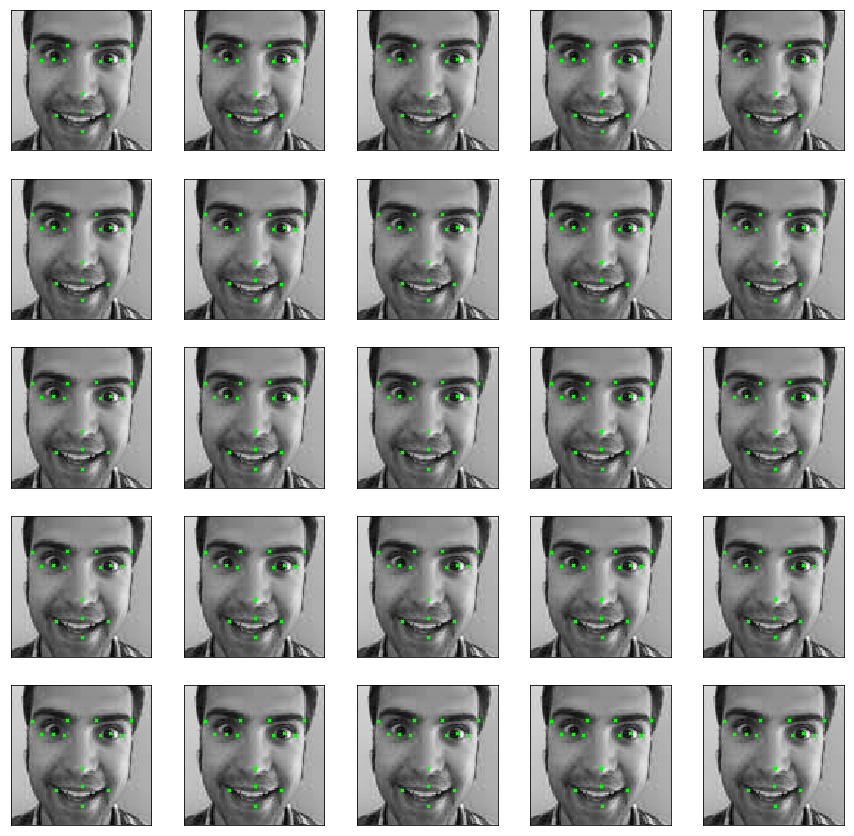

In [202]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = new_image
    img = img.reshape(96, 96)
    #y = y_test[i]
    y2 = pred[0]
    axis.imshow(img, cmap='gray')
    # Actual labels
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()